In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from transformers import EsmTokenizer, EsmForSequenceClassification, EsmModel, EsmConfig
from torch.optim import AdamW
from transformers import get_scheduler
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType
from focal_loss.focal_loss import FocalLoss

In [2]:
# Check if CUDA is available and set PyTorch to use GPU or CPU accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
max_length = 24
lr = 1e-3
num_epochs = 20
num_classes = 2

In [4]:
model_name = "../models/esm2_650M"
tokenizer = EsmTokenizer.from_pretrained(model_name)
model = EsmForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)

Some weights of the model checkpoint at ../models/esm2_650M were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at ../models/esm2_650M and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.de

## Get the physicochemical property labels
    positive label: net charge∈[2,7]; hydrophobicity∈[0.5,0.7]  
    negative label: out of that range  
<font size=3>The range has been learned through our recent work: https://doi.org/10.1101/2022.11.03.515123

In [5]:
def translate_to_code(pop):
    peptide=[]
    for acid in pop:
        peptide.append(dic_new[acid])
    
    return np.array(peptide)
    
def get_mean_hydrophobicity(pop): #hydrophobicity value calculations
    pop=translate_to_code(pop)
    
    hyd=[]
    for i in range(len(pop)):
        hyd.append(hydrophobicity[pop[i]])
    hyd=np.array(hyd)
    mean_hydrophobicity=sum(hyd)/(len(pop))
    return mean_hydrophobicity

def get_net_Charge(pop):# Net-charge calculations
    pop=translate_to_code(pop)
    
    elc=0
    for i in pop:
        i=int(i)
        if i==10 or i==15 or i==21:
            elc+=1
        elif i==9 or i==13:
            elc-=1
        else: pass 
    return np.array(elc,'float32')

In [6]:
amino_acid = {
    4: 'L', 
    5: 'A', 
    6: 'G', 
    7: 'V', 
    8: 'S', 
    9: 'E', 
    10: 'R', 
    11: 'T', 
    12: 'I', 
    13: 'D',
    14: 'P', 
    15: 'K', 
    16: 'Q', 
    17: 'N', 
    18: 'F', 
    19: 'Y', 
    20: 'M', 
    21: 'H', 
    22: 'W', 
    23: 'C'}
hydrophobicity={
    4: 1.700,
    5: 0.310,
    6: 0.,
    7: 1.220,
    8: -0.040,
    9: -0.640,
    10: -1.010,
    11: 0.260,
    12: 1.800,
    13: -0.770,
    14: 0.720,
    15: -0.990,
    16: -0.220,
    17: -0.600,
    18: 1.790,
    19: 0.960,
    20: 1.230,
    21: 0.130,
    22: 2.250,
    23: 1.540
}
dic_new = dict(zip(amino_acid.values(), amino_acid.keys()))

In [7]:
def get_fasta_dict(fasta_file):
    fasta_dict = {}
    with open(fasta_file, 'r') as infile:
        for line in infile:
            if line.startswith(">"):
                head = line.replace("\n", "").replace(">", "")
                fasta_dict[head] = ''
            else:
                fasta_dict[head] += line.replace("\n", "")
    return fasta_dict

def get_label(fasta_dict):
    label=[]
    for header,sequence in fasta_dict.items():
        charge=get_net_Charge(sequence)
        hy=get_mean_hydrophobicity(sequence)
        if 2.0 <= charge <= 7.0 and 0.5 <= hy <= 0.7:
            label.append(0)
        else:
            label.append(1)
    return label

In [8]:
class SeqDataset(torch.utils.data.Dataset):
    def __init__(self, fasta_dict) -> None:
        super().__init__()
        self.fasta_dict = fasta_dict
        self.names = [name for name in fasta_dict.keys()]
        self.labels = get_label(fasta_dict)
        
    def __getitem__(self, idx):
        seq_name = self.names[idx]
        selected_seq = self.fasta_dict[seq_name]
        label = self.labels[idx]
        
        return selected_seq, label
    
    def __len__(self):
        return len(self.names)

In [9]:
fasta_dict = get_fasta_dict('../database/LBD_135.fasta')
dataset = SeqDataset(fasta_dict)
print("Dataset checking:")
for i in tqdm(range(dataset.__len__())):
    seqs, label = dataset.__getitem__(i)

Dataset checking:


  0%|          | 0/135 [00:00<?, ?it/s]

In [10]:
label=get_label(fasta_dict)
from collections import Counter
c1 = Counter(label)
print(c1)

Counter({0: 71, 1: 64})


## Finetune the ESM2_t33_650M model with Lora

In [11]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

In [12]:
random_seed = 42
batch_size = 4
dataset_size = len(dataset)
train_sample_num = int(dataset_size * 0.8)

# Create a list of indices for the dataset
indices = list(range(dataset_size))

# Shuffle the indices using the random seed
np.random.seed(random_seed)
np.random.shuffle(indices)

# Split the indices into training and test sets using SubsetRandomSampler
train_indices = indices[:train_sample_num]
test_indices = indices[train_sample_num:]

train_dataset=[]
test_dataset=[]
for i in train_indices:
    train_dataset.append(dataset[i])
for i in test_indices:
    test_dataset.append(dataset[i])
    
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=2)
test_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=2)

In [13]:
# Set config file
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, 
    inference_mode=False, r=48, 
    lora_alpha=24,
    lora_dropout=0.6, 
    bias="none", 
    target_modules=["query","value","key"], 
    modules_to_save=["decode_head"], 
    # Ensure classification heads are set here to save so we do train them
)

# Initialize LoRA model
lora_model = get_peft_model(model, peft_config)
lora_model.print_trainable_parameters()

# Set up optimizer
optimizer = AdamW(lora_model.parameters(), lr=lr,weight_decay=5e-3)

# Calculate number of training steps
num_training_steps = num_epochs * len(train_loader)

lr_scheduler = get_scheduler(
    "linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps         #adjust the learning rate
)

# Initialize progress bar
progress_bar = tqdm(range(num_training_steps))

# Replacing the standard cross-entropy loss by a focal loss improved our results slightly.
# The gamma parameter is used to adjust the rate at which easy examples are down-weighted. When gamma is zero, Focal Loss is equivalent to Cross Entropy Loss.
# As gamma is increased, the effect of the modulating factor is likewise increased, i.e., the loss for well-classified examples (low loss) is down-weighted.
focal_loss = FocalLoss(gamma=1)

trainable params: 15449604 || all params: 666163865 || trainable%: 2.319189738698901


  0%|          | 0/540 [00:00<?, ?it/s]

In [14]:
# Define lists to store the training and validation accuracy for each fold
train_acc_list = []
test_acc_list = []
train_loss_list=[]
test_loss_list=[]

for epoch in range(num_epochs):
    train_acc = 0.0
    total = 0
    correct = 0
    # Train the model on the training set
    lora_model.train()
    
    for i, (s, l) in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        inputs = tokenizer(s, return_tensors='pt', padding="max_length", truncation=True, max_length=max_length).to(device)
        l = l.to(device)
        outputs = lora_model(**inputs, labels = l)
        logits = outputs.logits
        loss = focal_loss(torch.softmax(logits,dim=1), l.to(device))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        
        #calculate training accuracy
        predictions = torch.argmax(logits, dim=1)
        total += len(l)
        correct += (predictions == l).sum().item()
    train_acc=correct / total
        
    train_loss_list.append(loss.item())
    
    test_acc = 0.0
    total = 0
    correct = 0
    lora_model.eval()
   
    for i, (s, l) in enumerate(test_loader):
        inputs = tokenizer(s, return_tensors='pt', padding="max_length", truncation=True, max_length=max_length).to(device)
        l = l.to(device)
        with torch.no_grad():
            outputs = lora_model(**inputs, labels=l)
            logits = outputs.logits
            test_loss = focal_loss(torch.softmax(logits,dim=1), l.to(device))
            predictions = torch.argmax(logits, dim=1)
            total += len(l)
            correct += (predictions == l).sum().item()
            test_acc=correct / total
    
    test_loss_list.append(test_loss.item())    

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print("Epoch: {}, training_loss: {:.2f}, test_loss:{:.2f},training accuracy: {:.4f}, test accuracy: {:.4f} ".format(epoch, loss.item(), test_loss.item(), train_acc, test_acc))
    

Epoch: 0, training_loss: 0.30, test_loss:0.58,training accuracy: 0.5648, test accuracy: 0.6000 
Epoch: 1, training_loss: 0.20, test_loss:0.07,training accuracy: 0.6389, test accuracy: 0.8519 
Epoch: 2, training_loss: 0.24, test_loss:0.09,training accuracy: 0.8519, test accuracy: 0.7556 
Epoch: 3, training_loss: 0.34, test_loss:0.01,training accuracy: 0.7778, test accuracy: 0.9037 
Epoch: 4, training_loss: 0.02, test_loss:0.00,training accuracy: 0.9259, test accuracy: 0.9037 
Epoch: 5, training_loss: 0.09, test_loss:0.00,training accuracy: 0.8611, test accuracy: 0.5704 
Epoch: 6, training_loss: 0.07, test_loss:0.01,training accuracy: 0.8611, test accuracy: 0.9037 
Epoch: 7, training_loss: 0.06, test_loss:0.00,training accuracy: 0.9537, test accuracy: 0.9333 
Epoch: 8, training_loss: 0.02, test_loss:0.00,training accuracy: 0.9815, test accuracy: 0.9111 
Epoch: 9, training_loss: 0.12, test_loss:0.00,training accuracy: 0.9722, test accuracy: 0.9333 
Epoch: 10, training_loss: 0.00, test_los

In [ ]:
# peft_model_id = f"{model_name}_{peft_config.peft_type}_{peft_config.task_type}_{test_acc:.2f}"
# lora_model.save_pretrained(peft_model_id)

## Evaluate the fine-tuned model

In [17]:
config.base_model_name_or_path

'./esm/esm2_650M'

In [18]:
from peft import PeftModel, PeftConfig
config = PeftConfig.from_pretrained('../models/esm2_650M_LORA_SEQ_CLS_0.99')
model = EsmForSequenceClassification.from_pretrained('../models/esm2_650M', num_labels=num_classes)
 
model = PeftModel.from_pretrained(model, '../models/esm2_650M_LORA_SEQ_CLS_0.99')
model.eval()
model.to(device)

Some weights of the model checkpoint at ../models/esm2_650M were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at ../models/esm2_650M and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.de

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): EsmForSequenceClassification(
      (esm): EsmModel(
        (embeddings): EsmEmbeddings(
          (word_embeddings): Embedding(33, 1280, padding_idx=1)
          (dropout): Dropout(p=0.0, inplace=False)
          (position_embeddings): Embedding(1026, 1280, padding_idx=1)
        )
        (encoder): EsmEncoder(
          (layer): ModuleList(
            (0-32): 33 x EsmLayer(
              (attention): EsmAttention(
                (self): EsmSelfAttention(
                  (query): Linear(
                    in_features=1280, out_features=1280, bias=True
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.6, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=1280, out_features=48, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default)

In [20]:
test_dict = get_fasta_dict('../database/LBD_test.fasta')
dataset = SeqDataset(test_dict)
print("Dataset checking:")
seqs=[]
labels=[]
for i in tqdm(range(dataset.__len__())):
    seq, label = dataset.__getitem__(i)
    seqs.append(seq)
    labels.append(label)

tokens = tokenizer(seqs, return_tensors='pt', padding="max_length", truncation=True, max_length=max_length).to("cuda")
with torch.no_grad():
    outputs = model(**tokens)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)
    predictions=predictions.cpu()

Dataset checking:


  0%|          | 0/8 [00:00<?, ?it/s]

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_mat = confusion_matrix(labels, predictions)
report = classification_report(predictions, labels)
print(f"Confusion matrix: \n{confusion_mat}")
print(report)

Confusion matrix: 
[[5 1]
 [0 2]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.67      0.80         3

    accuracy                           0.88         8
   macro avg       0.92      0.83      0.85         8
weighted avg       0.90      0.88      0.87         8



### 2D UMAP plots

In [22]:
from umap import UMAP

/nfs/home/9403_huangjiaquan/.conda/envs/AMP/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/home/9403_huangjiaquan/.conda/envs/AMP/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/home/9403_huangjiaquan/.conda/envs/AMP/lib/python

In [24]:
test_dict = get_fasta_dict('../database/LBD.fasta')
dataset = SeqDataset(test_dict)
print("Dataset checking:")
seqs=[]
pp_label=[]
for i in tqdm(range(dataset.__len__())):
    seq, label = dataset.__getitem__(i)
    seqs.append(seq)
    pp_label.append(label)

inputs = tokenizer(seqs, return_tensors='pt', padding="max_length", truncation=True, max_length=max_length).to(device)
outputs=model.esm(**inputs,output_attentions=True,output_hidden_states=True)
test_lora_out=outputs.last_hidden_state

Dataset checking:


  0%|          | 0/30 [00:00<?, ?it/s]

In [25]:
umap_embeddings = UMAP(n_neighbors= 15, 
                             n_components= 3, 
                             metric='cosine', spread=1, local_connectivity=2, n_epochs=1000,
                             min_dist=1,
                             random_state= 420).fit_transform(test_lora_out.mean(1).cpu())

In [28]:
ac_label=[]
for i in range(len(test_dict.keys())):
    ac_label.append(list(test_dict.keys())[i].split('|')[-1])

df=pd.DataFrame(umap_embeddings,columns=["component_0","component_1","component_2"],index=ac_label)
df["property"]=pp_label

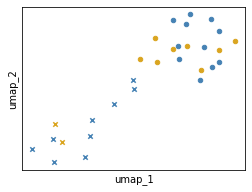

In [30]:
colors = ['#DAA520' if i=="positive" else '#4682B4' for i in ac_label]
shapes = ["o" if i==0 else "x" for i in pp_label]
plt.figure(figsize=[4,3])

for i in range(len(shapes)):
    plt.scatter(df.iloc[:,0][i], df.iloc[:,1][i], marker=shapes[i], color=colors[i], alpha=1,s=20)
    
plt.xticks([])
plt.yticks([])
plt.xlabel('umap_1')
plt.ylabel('umap_2')
# plt.savefig('./outputs/umap2d_lora_esm2.png',dpi=1000,bbox_inches='tight')
plt.show()